In [115]:
#pip install fairlearn
#https://fairlearn.github.io/api_reference/index.html

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [117]:
from shap.datasets import adult  # shap is only used its dataset utility
adult()[0].head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [118]:
import inspect
#Look at the function definition
print(inspect.getsource(adult))

def adult(display=False):
    """ Return the Adult census data in a nice package. """
    dtypes = [
        ("Age", "float32"), ("Workclass", "category"), ("fnlwgt", "float32"),
        ("Education", "category"), ("Education-Num", "float32"), ("Marital Status", "category"),
        ("Occupation", "category"), ("Relationship", "category"), ("Race", "category"),
        ("Sex", "category"), ("Capital Gain", "float32"), ("Capital Loss", "float32"),
        ("Hours per week", "float32"), ("Country", "category"), ("Target", "category")
    ]
    raw_data = pd.read_csv(
        cache(github_data_url + "adult.data"),
        names=[d[0] for d in dtypes],
        na_values="?",
        dtype=dict(dtypes)
    )
    data = raw_data.drop(["Education"], axis=1)  # redundant with Education-Num
    filt_dtypes = list(filter(lambda x: not (x[0] in ["Target", "Education"]), dtypes))
    data["Target"] = data["Target"] == " >50K"
    rcode = {
        "Not-in-family": 0,
        "Unmarried": 1,
      

In [119]:
X, y_true = adult(display=True) #Raw dataset
X.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


## Remove the Sex and Race as we do not want a biased model based on these

In [165]:
X_raw, y_true = adult(display=False) #Factorize the cats
print(X_raw.head(1))
#'remove 'Sex' and 'Race' from the model so they do not cause bias 
X = X_raw.drop(labels=['Sex','Race'], axis=1)

print(X.head(1))


    Age  Workclass  Education-Num  Marital Status  Occupation  Relationship  \
0  39.0          7           13.0               4           1             0   

   Race  Sex  Capital Gain  Capital Loss  Hours per week  Country  
0     4    1        2174.0           0.0            40.0       39  
    Age  Workclass  Education-Num  Marital Status  Occupation  Relationship  \
0  39.0          7           13.0               4           1             0   

   Capital Gain  Capital Loss  Hours per week  Country  
0        2174.0           0.0            40.0       39  


In [166]:
print(y_true)
y_true = y_true * 1 #convert y to bianry numeric
print(y_true)

[False False False ... False False  True]
[0 0 0 ... 0 0 1]


In [167]:
sex = X_raw['Sex'].apply(lambda sex: "female" if sex == 0 else "male") #convert sex to male/female
sex

0          male
1          male
2          male
3          male
4        female
          ...  
32556    female
32557      male
32558    female
32559      male
32560    female
Name: Sex, Length: 32561, dtype: object

<BarContainer object of 2 artists>

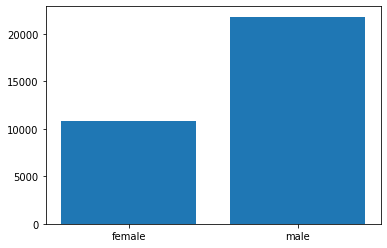

In [168]:
import matplotlib.pyplot as plt
dfgroup = pd.DataFrame(sex).groupby(['Sex'])['Sex'].count()
plt.bar(['female','male'], dfgroup)

### Train a model

In [169]:
from fairlearn.metrics import group_summary
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
classifier.fit(X, y_true)

y_pred = classifier.predict(X)
group_summary(accuracy_score, y_true, y_pred, sensitive_features=sex)

#Model has greater accuracy for females
#'female': 0.9958221149382601, 'male': 0.9668196420376319

{'overall': 0.972881668253432,
 'by_group': {'female': 0.9938724352427816, 'male': 0.9625057365764113}}

In [171]:
from fairlearn.metrics import selection_rate_group_summary
#Percent of data points marked as True 
selection_rate_group_summary(y_true, y_pred, sensitive_features=sex)
#Males have a higher percentage chance of getting a loan
#'female': 0.1065824900194968, 'male': 0.28347865993575033
#Bias in previous loans entering the model

{'overall': 0.22198335431958477,
 'by_group': {'female': 0.10481849410453997, 'male': 0.27989903625516294}}

In [172]:
from fairlearn.widget import FairlearnDashboard
FairlearnDashboard(sensitive_features=sex,
                       sensitive_feature_names=['sex'],
                       y_true=y_true,
                       y_pred={"initial model": y_pred})

FairlearnWidget(value={'true_y': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1…

In [173]:
#Get the race details
Xrace, delme = adult(display=True) #Raw dataset
Xrace = Xrace[['Race']]
Xrace

,Race
0,White
1,White
2,White
3,Black
4,Black
...,...
32556,White
32557,White
32558,White
32559,White


In [174]:
#Accuracy by race
group_summary(accuracy_score, y_true, y_pred, sensitive_features=Xrace)

{'overall': 0.972881668253432,
 'by_group': {' Amer-Indian-Eskimo': 0.9903536977491961,
  ' Asian-Pac-Islander': 0.9932627526467758,
  ' Black': 0.984955185659411,
  ' Other': 0.992619926199262,
  ' White': 0.9703767615760713}}

In [175]:
#Percentage of by race
selection_rate_group_summary(y_true, y_pred, sensitive_features=Xrace)

{'overall': 0.22198335431958477,
 'by_group': {' Amer-Indian-Eskimo': 0.11254019292604502,
  ' Asian-Pac-Islander': 0.2627526467757459,
  ' Black': 0.11331626120358515,
  ' Other': 0.09225092250922509,
  ' White': 0.2351524302559678}}

In [176]:
sexrace = pd.concat([sex, Xrace], axis=1)

In [177]:
from fairlearn.widget import FairlearnDashboard
FairlearnDashboard(sensitive_features=sexrace,
                       sensitive_feature_names=['sex', 'race'],
                       y_true=y_true,
                       y_pred={"initial model": y_pred})

FairlearnWidget(value={'true_y': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1…

# Run the mitigator to get a less bias model

In [178]:
%%time
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, GridSearch
constraint = DemographicParity()
classifier = DecisionTreeClassifier()
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features=sex)
y_pred_mitigated = mitigator.predict(X)
selection_rate_group_summary(y_true, y_pred_mitigated, sensitive_features=sex)

{'overall': 0.2622769570959123,
 'by_group': {'female': 0.2515086807167394, 'male': 0.2675998164295548}}

In [181]:
#View the results
FairlearnDashboard(sensitive_features=sex,
                       sensitive_feature_names=['sex'],
                       y_true=y_true,
                       y_pred={"initial model": y_pred, "mitigated model": y_pred_mitigated})

FairlearnWidget(value={'true_y': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1…

## Create some more models

In [182]:
%%time
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, GridSearch
mitigatorExponentiatedGradient = ExponentiatedGradient(DecisionTreeClassifier(), DemographicParity())
mitigatorExponentiatedGradient.fit(X, y_true, sensitive_features=sex)
y_pred_mitigatedExponentiatedGradient = mitigatorExponentiatedGradient.predict(X)

CPU times: user 1min 7s, sys: 189 ms, total: 1min 8s
Wall time: 1min 7s


In [183]:
%%time
mitigatorGridSearch = GridSearch(DecisionTreeClassifier(), DemographicParity())
mitigatorGridSearch.fit(X, y_true, sensitive_features=sex)
y_pred_mitigatedGridSearch = mitigatorGridSearch.predict(X)

CPU times: user 26.9 s, sys: 315 ms, total: 27.2 s
Wall time: 26.6 s


In [188]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(solver='liblinear', fit_intercept=True)
lg.fit(X, y_true)
y_pred_lg = lg.predict(X)

In [189]:
FairlearnDashboard(sensitive_features=sex,
                       sensitive_feature_names=['sex'],
                       y_true=y_true,
                       y_pred={"initial model": y_pred, "mitigated model Grid Search": y_pred_mitigatedGridSearch,  "mitigated model Exponentiated Gradient": y_pred_mitigatedExponentiatedGradient, "Logistic Regression": y_pred_lg})

FairlearnWidget(value={'true_y': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1…